# Recovery of gold from ore

It is necessary to prepare a prototype machine learning model to predict the recovery rate of gold from gold ore. There are data with production and purification parameters.

The goal of the model is to optimize production so as not to launch an enterprise with unprofitable characteristics.

## Data preprocessing

### Introduction

**Data is in three files:**

- `gold_recovery_train_new.csv` — training sample;
- `gold_recovery_test_new.csv` — test sample;
- `gold_recovery_full_new.csv` - source data.

**Data is indexed by the date and time the information was received (the `date` sign). Parameters adjacent in time are often similar.**

**Some parameters are not available because they are measured and/or calculated much later. Because of this, the test sample lacks some features that may be in the training sample. Also, there are no target features in the test set.**

**The original dataset contains training and test samples with all the features.**

**We have raw data at our disposal: it was simply unloaded from storage.**

### Technological process
**How is gold obtained from ore?
When the mined ore undergoes primary processing, a crushed mixture is obtained. It is sent for flotation (enrichment) and two-stage purification.**

![eng_final_smape](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/eng_process.png)

Let's describe each stage:

**1. Flotation**

A mixture of gold ore is fed into the flotation unit. After enrichment, a rough concentrate and “waste tailings” are obtained, that is, the remains of a product with a low concentration of valuable metals.

The stability of this process is affected by the inconsistent and suboptimal physicochemical state of the flotation pulp (a mixture of solid particles and liquid).

**2. Cleaning**

The rough concentrate undergoes two purifications. The output is a final concentrate and new tailings.

**Description of data**

**Technological process**

- *Rougher feed*** - feedstock
- *Rougher additions (or reagent additions)*** - flotation reagents: Xanthate, Sulphate, Depressant
   - *Xanthate* - xanthate (promoter, or flotation activator);
   - *Sulphate* - sulfate (in this production, sodium sulfide);
   - *Depressant* - depressant (sodium silicate).
- *Rougher process* (English “rough process”) - flotation
- *Rougher tails* - dump tails
- *Float banks* - flotation unit
- *Cleaner process* - cleaning
- *Rougher Au* - rough gold concentrate
- *Final Au* - final gold concentrate

**Stage parameters**
- *air amount* - volume of air
- *fluid levels* — fluid level
- *feed size* — size of raw material granules
- *feed rate* — feed speed

**Name of features**

The name of the features should be as follows:
`[stage].[parameter_type].[parameter_name]`


Example: `rougher.input.feed_ag`

Possible values for the `[stage]` block:
- *rougher* - flotation
- *primary_cleaner* - primary cleaning
- *secondary_cleaner* - secondary cleaning
- *final* - final characteristics

Possible values for the `[parameter_type]` block:
- *input* — parameters of raw materials
- *output* — product parameters
- *state* — parameters characterizing the current state of the stage
- *calculation* — calculated characteristics

**Efficiency calculation**

You need to model the process of recovering gold from gold ore. .
The enrichment efficiency is calculated using the formula

![recovery](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/recovery.png)

Where:
- *C*—the proportion of gold in the concentrate after flotation/refining;
- *F* — the share of gold in the raw material/concentrate before flotation/refining;
- *T* is the share of gold in the waste tailings after flotation/refining.

To predict the coefficient, you need to find the share of gold in concentrates and tailings.

Moreover, not only the final product is important, but also the rough concentrate.

**Quality Metric**
To solve the problem, we introduce a new quality metric - **sMAPE** (English *Symmetric Mean Absolute Percentage Error*, “symmetric mean absolute percentage deviation”).

It is similar to *MAE*, but is expressed not in absolute values, but in relative ones. Why *symmetrical*? It equally takes into account the scale of both the target feature and the prediction.

The *sMAPE* metric is calculated as follows:

![smape](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/smape.png)

**Notation:**

- ***Yi*** - The value of the target feature for the object with serial number i in the sample on which the quality is measured.

- ***Ẏi*** - Prediction value for an object with serial number i, for example, in a test sample.

- ***N*** - Number of objects in the sample.

- ***Σ*** - Summation over all sample objects (i varies from 1 to N).

It is necessary to predict two quantities (target features):

1. efficiency of rough concentrate enrichment `rougher.output.recovery`;
2. efficiency of enrichment of the final concentrate `final.output.recovery`.

The final metric consists of two values:

![eng_final_smape](https://github.com/dsintheocean/gold-recovery-prediction/raw/main/eng_final_smape.png)

### Import the libraries necessary for the work

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import make_scorer

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Let's study the data inside the dataframe and do the necessary preprocessing

In [6]:
train = pd.read_csv('/content/drive/My Drive/projects/mining_gold_recovery_percentage_prediction/gold_recovery_train_new.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/My Drive/projects/mining_gold_recovery_percentage_prediction/gold_recovery_test_new.csv', parse_dates=['date'])
data = pd.read_csv('/content/drive/My Drive/projects/mining_gold_recovery_percentage_prediction/gold_recovery_full_new.csv', parse_dates=['date'])

data_list = [data, train, test]
pd.set_option('display.max_columns', None)

for df in data_list:
     display(df.head(100)); #display the first 5 rows of the dataset
     display(df.info()); #display information about data types and gaps in the dataset
     print('Number of duplicates =', df['date'].duplicated().sum()) # number of duplicates by date/time
     display(df.describe()); #display information about the distribution of values in the dataset
     display(df.corr(numeric_only=True)); #let's look at the correlation between features
     print('\n\n')

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                19439 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         19438 non-null  float64       
 2   final.output.concentrate_pb                         19438 non-null  float64       
 3   final.output.concentrate_sol                        19228 non-null  float64       
 4   final.output.concentrate_au                         19439 non-null  float64       
 5   final.output.recovery                               19439 non-null  float64       
 6   final.output.tail_ag                                19438 non-null  float64       
 7   final.output.tail_pb                                19338 non-null  float64       
 8   final.

None

Number of duplicates = 0


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.063570,0.380142,-0.038373,0.185952,0.334596,-0.051855,0.028890,0.206569,0.071158,0.127827,0.040543,0.127175,0.509877,-0.152814,0.332771,-0.200367,0.043138,-0.023182,0.175824,0.163903,0.175978,0.039789,0.194615,0.058284,0.154360,0.036542,0.110360,-0.001388,-0.014190,-0.034702,-0.039130,0.158668,0.456279,0.074866,-0.167154,-0.043895,-0.036783,0.315817,-0.096561,0.093678,-0.113477,0.114032,0.315558,-0.127291,-0.018497,0.044347,0.084148,0.204522,-0.049453,0.008952,0.125401,0.102807,-0.206426,0.086768,0.094650,0.079634,0.099465,0.094354,0.094249,0.135264,0.104504,0.091003,0.097289,-0.039046,-0.286238,0.157687,0.048926,-0.058101,0.024641,-0.016135,0.024709,0.061833,0.116037,0.065680,0.138392,0.027343,0.104118,0.029887,-0.063246,-0.004246,0.184332,0.003693,0.156471,0.162591,0.059581
final.output.concentrate_pb,0.063570,1.000000,-0.048586,0.374400,0.151987,-0.126886,0.221372,0.094385,-0.047446,0.079160,0.037710,-0.083249,-0.080320,-0.036563,0.377527,-0.110350,0.010703,-0.021533,0.026415,-0.048739,-0.138511,-0.002548,0.075751,-0.02

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   date                                                14149 non-null  datetime64[ns]
 1   final.output.concentrate_ag                         14148 non-null  float64       
 2   final.output.concentrate_pb                         14148 non-null  float64       
 3   final.output.concentrate_sol                        13938 non-null  float64       
 4   final.output.concentrate_au                         14149 non-null  float64       
 5   final.output.recovery                               14149 non-null  float64       
 6   final.output.tail_ag                                14149 non-null  float64       
 7   final.output.tail_pb                                14049 non-null  float64       
 8   final.

None

Number of duplicates = 0


,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
final.output.concentrate_ag,1.000000,0.021110,0.351985,-0.104934,0.133238,0.289552,-0.099818,0.045896,0.193935,0.015923,0.136008,0.024921,0.165403,0.502774,-0.176998,0.315810,-0.185916,-0.001483,-0.062081,0.165046,0.191298,0.188219,0.041814,0.203256,0.053429,0.165760,0.043158,0.098070,0.007139,-0.016921,-0.027763,-0.037668,0.195373,0.424378,0.004272,-0.177363,-0.021952,-0.045802,0.276645,-0.115623,0.069868,-0.140668,0.087768,0.288717,-0.167535,-0.042561,0.033109,0.037976,0.191569,-0.032464,0.023109,0.131941,0.115834,-0.188839,0.119946,0.083973,0.099507,0.087969,0.129379,0.083580,0.187447,0.100778,0.153916,0.097132,-0.080417,-0.309225,0.142095,0.044370,-0.061512,0.036827,-0.025608,0.039360,0.054267,0.180700,0.027815,0.208832,0.041765,0.169538,0.020832,0.005319,0.013019,0.228753,0.021660,0.199048,0.170298,0.061009
final.output.concentrate_pb,0.021110,1.000000,-0.008451,0.320916,0.095000,-0.100616,0.240650,0.068287,0.029186,0.124170,0.012164,-0.051249,-0.179346,-0.031388,0.390204,-0.081883,0.008804,-0.042722,0.004041,-0.019916,-0.127692,-0.023678,0.062319,-0.04317

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   date                                        5290 non-null   datetime64[ns]
 1   primary_cleaner.input.sulfate               5286 non-null   float64       
 2   primary_cleaner.input.depressant            5285 non-null   float64       
 3   primary_cleaner.input.feed_size             5290 non-null   float64       
 4   primary_cleaner.input.xanthate              5286 non-null   float64       
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64       
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64       
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64       
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64       
 9   primary_

None

Number of duplicates = 0


,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
primary_cleaner.input.sulfate,1.000000,0.455718,0.114456,0.497568,0.102653,0.048032,0.075737,0.138949,0.024710,0.027697,0.095001,-0.020533,0.359619,0.428382,0.464251,-0.009796,0.423859,0.437016,0.617768,0.557307,0.583022,0.527014,0.236898,0.222913,-0.230670,-0.047665,-0.247043,-0.051896,-0.247163,-0.016032,-0.234958,-0.120379,-0.250187,-0.063497,0.051989,-0.039145,0.254702,-0.011921,0.136986,0.003869,0.148037,0.020303,0.305793,0.117976,0.348395,0.068693,0.093608,0.132193,0.156583,0.072618,-0.134499,0.033945
primary_cleaner.input.depressant,0.455718,1.000000,0.215703,0.150760,0.144443,0.242592,0.148658,0.201499,0.036655,0.207632,0.141651,0.082802,0.497866,0.465961,0.132437,0.004431,0.169735,0.460965,0.240528,0.347558,0.208050,0.361123,0.422574,0.133122,-0.355519,-0.112394,-0.366098,-0.102649,-0.346803,-0.079246,-0.361011,-0.129417,-0.376446,-0.110906,0.084117,-0.084408,0.234562,-0.098847,0.282703,0.125933,0.256512,0.115952,0.326090,0.117510,0.238618,-0.085583,-0.090184,0.009138,0.064209,0.002988,-0.198422,0.034654
primary_cleaner.input.feed_size,0.114456,0.215703,1.000000,-0.291792,-0.064628,0.082869,-0.063490,0.071470,-0.091542,0.066384,-0.074156,0.065808,0.338795,0.000398,0.020000,-0.087331,0.054595,0.238692,-0.187934,0.224360,-0.236345,0.185176,0.023678,-0.236632,0.044605,0.051614,0.064617,0.049608,-0.009526,0.073623,-0.012558,0.006890,-0.129796,0.036627,-0.128933,0.044605,-0.184586,0.005911,0.024193,0.032868,-0.017527,0.025709,-0.148328,-0.121148,-0.173658,-0.137180,-0.192880,-0.059167,-0.214970,-0.054173,0.026930,-0.083021
primary_cleaner.input.xanthate,0.497568,0.150760,-0.291792,1.000000,0.209017,-0.059553,0.153527,0.016144,0.044194,-0.078742,0.174791,-0.144240,0.048319,0.241138,0.464682,0.195665,0.370448,0.093609,0.581118,0.350009,0.593851,0.368205,0.402757,0.424760,-0.387143,-0.342816,-0.405743,-0.346091,-0.392980,-0.326506,-0.321572,-0.363457,-0.290621,-0.333947,-0.038919,-0.162965,0.220744,-0.113589,-0.049184,-0.034554,-0.050835,-0.009169,0.313377,0.131178,0.360961,0.121575,0.059162,0.128636,0.077380,0.095508,-0.218155,0.080662
primary_cleaner.state.floatbank8_a_air,0.102653,0.14

**Let's check that the recovery efficiency is calculated correctly and the data intended for use is correct. To do this, we calculate it on the training set for the feature `rougher.output.recovery` and find the MAE between the calculated value and the value of the feature.**

In [7]:
def mae_recovery_calc(data,c,f,t,recovery):
     """
     Function for calculating MAE between the calculated Recovery value and the value of a feature from the dataset.
     df - dataset,
     recovery — name of the feature in the dataframe,
     c — name of the feature in the dataframe, corresponding to the share of gold in the concentrate after flotation/refining,
     f — name of the attribute in the dataframe, the corresponding share of gold in the raw material/concentrate before flotation/refining,
     t is the name of the feature in the dataframe, corresponding to the share of gold in the waste tailings after flotation/cleaning.
     """
     def calc_recovery(row):
         """
         Returns the estimated recovery, taking into account possible zero in the denominator of the expression
         """
         calc_recovery = 0
         if (row[f] * (row[c] - row[t])) == 0:
             calc_recovery = float('nan')
         else:
             calc_recovery = 100 * row[c] * (row[f] - row[t]) / (row[f] * (row[c] - row[t]))
         return calc_recovery

     df = data.copy()
     df['calc_recovery'] = df.apply(calc_recovery, axis=1)
     #create a parameter module of the difference between the predictor and the target
     df['abs_of_diff'] = abs(df[recovery] - df['calc_recovery'])
     mae_calc = df['abs_of_diff'].sum() / len(df)
     return mae_calc

print('MAE between the calculated Recovery and the rougher.output.recovery parameter in the training set =',
       mae_recovery_calc(
           train,'rougher.output.concentrate_au','rougher.input.feed_au',
           'rougher.output.tail_au','rougher.output.recovery')
      )

MAE between the calculated Recovery and the rougher.output.recovery parameter in the training set = 1.1498046842860452e-14


**We obtained the value MAE = 1.15 * 10^(-14), which is very close to 0. Therefore, we can conclude that the data provided and the formula for calculating Recovery are correct.**

**What conclusions can be drawn from the data above:**

- The date parameter `date` in all datasets has the object type, it is necessary to convert it to a convenient type for work - datetime, we will do this above in the block for reading csv files, specifying a column to change the type to datetime using the parse_dates attribute.
- The number of gaps in the source data (data) is not large; below we will calculate the percentage of gaps for each parameter and fill in the gaps in all samples. It’s a positive fact that in the samples there are no gaps in the `date` parameter, which is responsible for the date and time.
- In the training set and the original data, the number of parameters is the same, while in the test set it is not. It will be necessary to supplement the test set with the missing target parameters, and, possibly, remove some parameters from the training set that are not present in the test set.
- The number of parameters in the source data is quite large, so the information about the correlation is unreadable, let's fix this by creating a dictionary in which each of the parameters will be the key, and the key corresponds to a table with the top parameters by correlation with the key parameter and the value of this correlation.
- The parameter values are quite different from each other, so in the future it will be necessary to standardize them to obtain better results in model predictions.

In [8]:
#let's count the gaps as a percentage of the total amount of data for each parameter for each sample
def isna_percent(df):
     return df.isna().mean().sort_values(ascending=False).head()

for df in data_list:
     display(isna_percent(df))

secondary_cleaner.output.tail_sol           0.089922
rougher.input.floatbank11_xanthate          0.023304
rougher.state.floatbank10_e_air             0.022429
primary_cleaner.output.concentrate_sol      0.019034
secondary_cleaner.state.floatbank2_a_air    0.011317
dtype: float64

secondary_cleaner.output.tail_sol           0.113436
rougher.state.floatbank10_e_air             0.030815
rougher.input.floatbank11_xanthate          0.030249
primary_cleaner.output.concentrate_sol      0.020213
secondary_cleaner.state.floatbank2_a_air    0.015337
dtype: float64

rougher.input.floatbank11_xanthate          0.004726
rougher.input.feed_sol                      0.003970
secondary_cleaner.state.floatbank3_a_air    0.001701
rougher.input.floatbank11_sulfate           0.001512
primary_cleaner.input.depressant            0.000945
dtype: float64

**We see that there are no more than a few percent gaps in the parameters, with the exception of the `secondary_cleaner.output.tail_sol` parameter - it contains 11% in the training set and 9% in the original one. Because in the original problem it is indicated that** *data is indexed by the date and time of receipt of information (date sign) and parameters adjacent in time are often similar,* **then we will fill in the gaps in the data using the fillna method indicating the value ffil of the method parameter, which allows Fill in the missing value with the closest previous valid value.**

In [9]:
data = data.fillna(method='ffill') #fill the gaps with the adjacent value
data.isna().sum().sum() #check for gaps

0

**Now let’s fill in the gaps in the test and training samples with values from the completed original sample. The synchronization parameter is the `date` parameter.**

In [10]:
def fill_df1nan_with_df2 (df1, df2, comm_col1, comm_col2):
     df1 = df1.set_index(comm_col1).fillna(df2.set_index(comm_col2)).reset_index()
     return df1

train = fill_df1nan_with_df2(train, data, 'date', 'date')
test = fill_df1nan_with_df2(test, data, 'date', 'date')
print(f'Number of gaps in the sample train = {train.isna().sum().sum()}')
print(f'Number of gaps in sample test = {test.isna().sum().sum()}')

Number of gaps in the sample train = 0
Number of gaps in sample test = 0


**We will analyze the features that are not available in the test sample, determine what these parameters are and what type they belong to.**

In [11]:
def columns_diff(data, test):
     """
     The function generates a dataframe with the name of the columns\parameters and their type,
     which are in one df, and not in another df, which are fed to the input
     """
     data_columns_list = data.columns.values.tolist() # form a list from the names of the parameters in the source data
     test_columns_list = test.columns.values.tolist() # form a list of parameter names in the test sample
     data_test_columns_diff = list(set(data_columns_list).difference(set(test_columns_list))) # list of differences between data and test
     if len(data_test_columns_diff):
         data_test_columns_diff_df = pd.DataFrame(data_test_columns_diff).rename(columns = {0: 'parameter'})
         data_columns_type_df = pd.DataFrame(data.dtypes).reset_index().rename(columns = {0: 'type', 'index': 'parameter'})
         data_test_columns_diff_w_types = pd.merge(data_test_columns_diff_df, data_columns_type_df)
     else:
         return 'The parameters/columns of the two samples are not different'
     return data_test_columns_diff_w_types
columns_diff(train, test)

,parameter,type
0,final.output.tail_au,float64
1,rougher.output.tail_ag,float64
2,rougher.output.concentrate_ag,float64
3,primary_cleaner.output.tail_sol,float64
4,final.output.tail_pb,float64
5,rougher.output.tail_au,float64
6,rougher.output.concentrate_au,float64
7,rougher.output.concentrate_sol,float64
8,rougher.calculation.floatbank11_sulfate_to_au_...,float64
9,final.output.tail_ag,float64


**As we can see, among the missing parameters there are both target features and regular features. It will be necessary to remove regular features (besides the target features) from the training set, because they do not participate in the test sample, and the model must be checked on the test sample using the same features on which we trained it. As for the missing target features, they will need to be added to the test sample. Let's do it below.**

In [12]:
test = test.merge(data[['date', 'rougher.output.recovery', 'final.output.recovery']], how='left', on='date')

train = train.copy()
train = train.drop(
     labels=list(
         set(list(set(train.columns.values.tolist()).difference(set(test.columns.values.tolist()))))
         .difference
         (set(['rougher.output.recovery', 'final.output.recovery']))
                )
     , axis=1)
columns_diff(train, test)

'The parameters/columns of the two samples are not different'

**The number of parameters in the source data is quite large, so the information about the correlation is unreadable, we will correct this by creating a dictionary in which each of the parameters will be the key, and the key corresponds to a table with the top parameters modulo the correlation value with the key parameter and the value of this correlation without module.**

In [14]:
data_corr = data.corr(numeric_only=True) #correlation matrix based on data in data
dict_top_corr_data = {} #dictionary with keys by parameter names containing top correlations with other parameters

for column in data_corr.columns: # loop through the columns in the correlation matrix based on the data in data
     #make a dataframe from one column, corr. take it modulo to make it easier to compare and delete the line
     #with the same parameter, because there correlation = 1
     column_corr = data_corr[column].to_frame().drop(column)
     column_corr_abs = column_corr.abs()
     #select the indices of those values where the condition is satisfied
     index_top = column_corr_abs[(column_corr_abs[column] >= 0.3)].index
     #save the top correlations for this parameter into the dictionary
     dict_top_corr_data[column] = column_corr.loc[index_top]

dict_top_corr_data['final.output.recovery'] #display a table for one parameter key as an example

,final.output.recovery
final.output.tail_au,-0.409200
primary_cleaner.input.sulfate,0.355877
primary_cleaner.output.tail_au,-0.391106
rougher.input.floatbank10_xanthate,0.324669
rougher.input.floatbank11_xanthate,0.311190
rougher.output.recovery,0.327059
rougher.output.tail_pb,-0.317056
rougher.output.tail_au,-0.313320
secondary_cleaner.output.tail_au,-0.334696


## Exploratory Data Analysis

### Estimation of metal concentrations at various stages of purification

**First, let's look at how the concentration of metals (Au, Ag, Pb) changes at different stages of purification in the original data.**

In [15]:
def str_in_param(str_var, df):
     """
     A function that searches for a given string in variable names/dataset columns
     and generates a list of these variables/columns as output
     """
     list_feed_param = []
     for i in range(len(df.columns.tolist())):
         if str_var in df.columns.tolist()[i]:
             t = df.columns.tolist()[i]
             list_feed_param.append(t)
     return list_feed_param
str_in_param('concentrate_au', data) #let's check the function using the example of the gold concentration parameter

['final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_au']

In [16]:
str_in_param('rougher.input.feed', data) #let's look at the parameters that characterize the primary raw material

['rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

In [17]:
for var in ['au', 'ag', 'pb']:
    #plt.figure(figsize=(15,7))
    for param in (str_in_param('feed_'+var, data)+str_in_param('concentrate_'+var, data)):
        print(f'median of {param}')

median of rougher.input.feed_au
median of final.output.concentrate_au
median of primary_cleaner.output.concentrate_au
median of rougher.output.concentrate_au
median of rougher.input.feed_ag
median of final.output.concentrate_ag
median of primary_cleaner.output.concentrate_ag
median of rougher.output.concentrate_ag
median of rougher.input.feed_pb
median of final.output.concentrate_pb
median of primary_cleaner.output.concentrate_pb
median of rougher.output.concentrate_pb


**Let's look at the distributions and median values for the concentration of each metal at various stages of the technological process.**

median of rougher.input.feed_au in data = 8.125838836648287
median of final.output.concentrate_au in data = 45.01124391455689
median of primary_cleaner.output.concentrate_au in data = 32.841295480233306
median of rougher.output.concentrate_au in data = 20.280214025891475


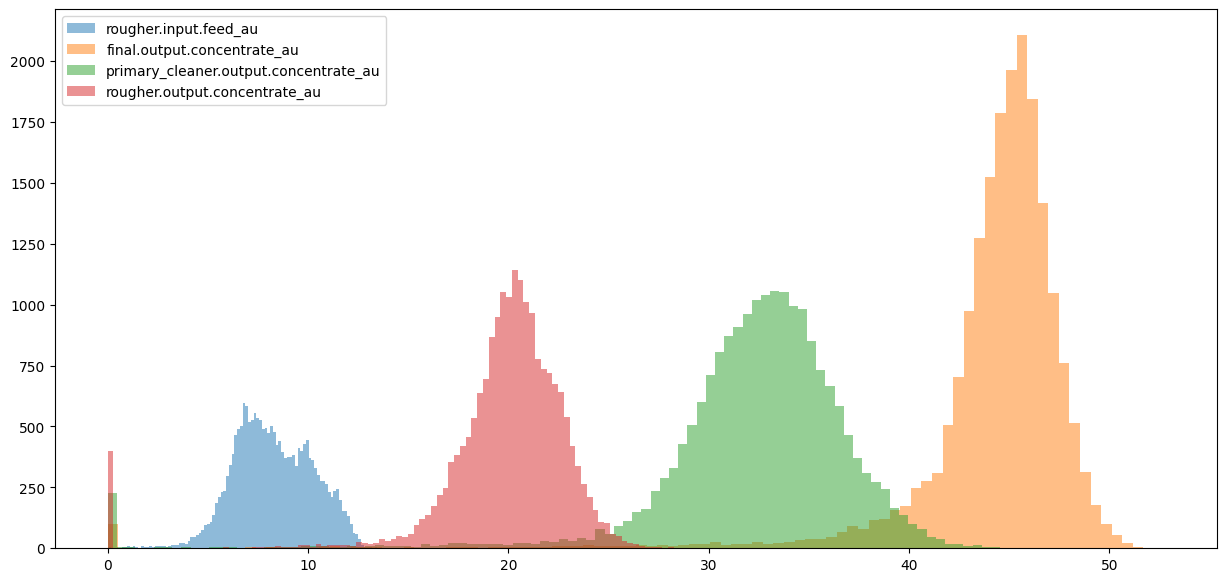

median of rougher.input.feed_ag in data = 8.593574167368724
median of final.output.concentrate_ag in data = 5.066039118467836
median of primary_cleaner.output.concentrate_ag in data = 8.507297972365805
median of rougher.output.concentrate_ag in data = 12.098114967346191


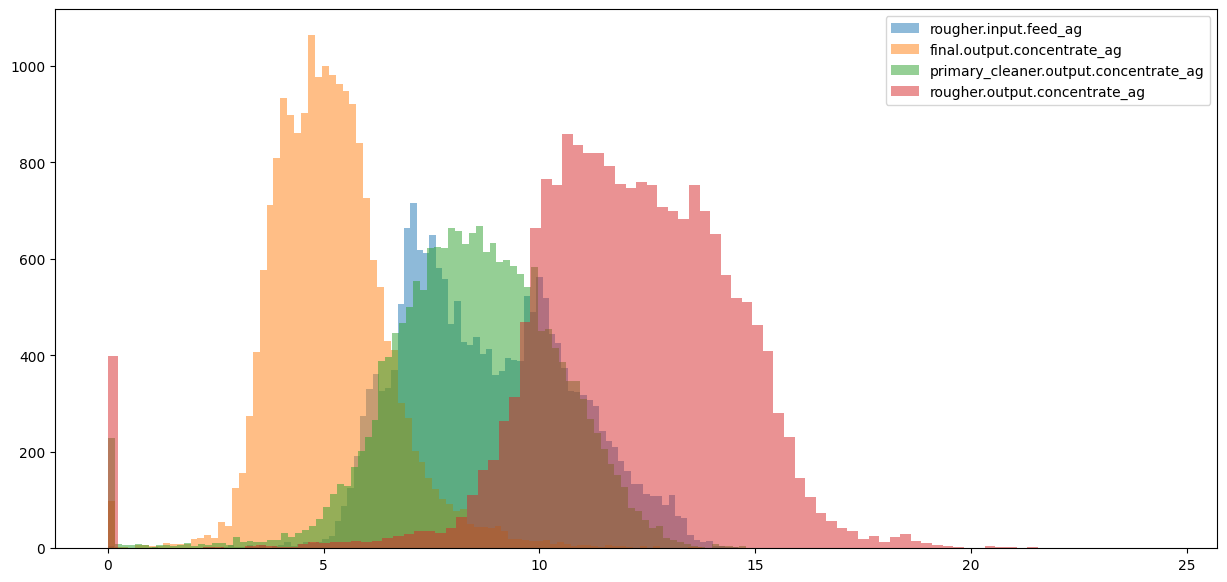

median of rougher.input.feed_pb in data = 3.5282347219520145
median of final.output.concentrate_pb in data = 10.10226350598865
median of primary_cleaner.output.concentrate_pb in data = 10.142270415359071
median of rougher.output.concentrate_pb in data = 7.742580079502529


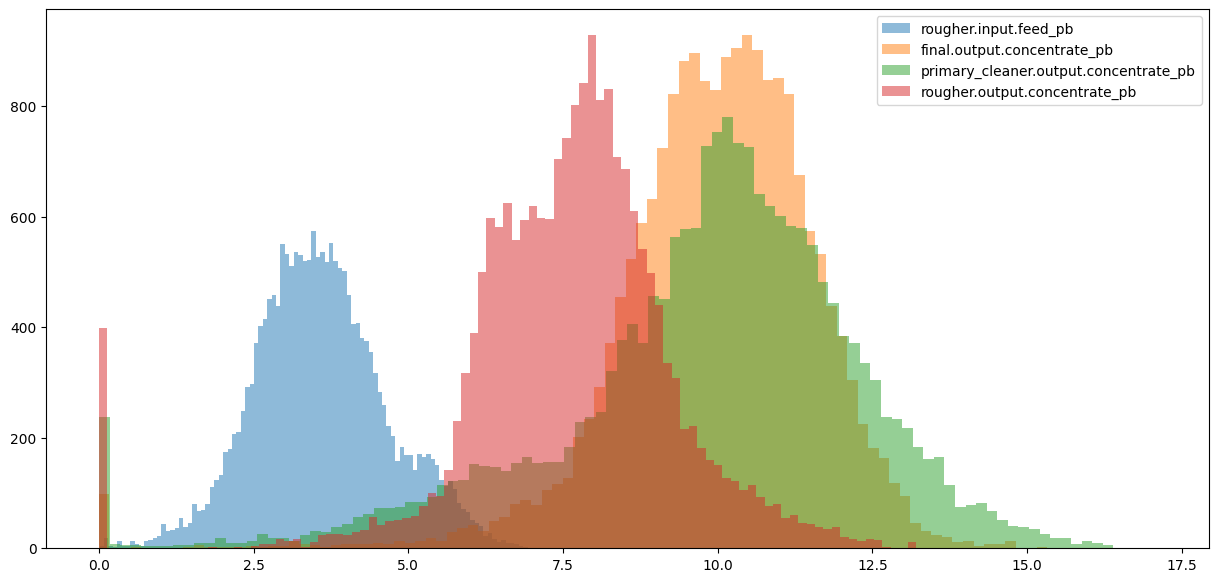

In [18]:
for var in ['au', 'ag', 'pb']:
    plt.figure(figsize=(15,7))
    for param in (str_in_param('feed_'+var, data)+str_in_param('concentrate_'+var, data)):
        print(f'median of {param} in data =', data[param].median())
        plt.hist(data[param], bins=100, alpha=0.5, label=param);
    plt.legend(loc='best')
    plt.show();

**Based on the data above, the following conclusions can be drawn:**
- The concentration of gold increases greatly as successive stages of the technological process (refining and enrichment) pass through;
- The concentration of silver increases after the flotation stage, and then decreases as the remaining stages of the technological process progress;
- The concentration of lead grows slightly as the stages of the technological process progress, and after the 1st stage of purification and at the final stage it is almost the same;
- In the concentration data of each metal there are outlier values equal to zero, which can affect the further operation of the model and the sMAPE metric; it is necessary to estimate what percentage of the data cover these values in the training set.

In [19]:
for var in ['au', 'ag', 'pb']:
     for param in (str_in_param('feed_'+var, data)+str_in_param('concentrate_'+var, data)):
         percent = data[data[param] == 0]['date'].count()/len(data)*100
         print(f'Percentage of zero parameter values {param} = {percent:.3f}')

Percentage of zero parameter values rougher.input.feed_au = 0.000
Percentage of zero parameter values final.output.concentrate_au = 0.504
Percentage of zero parameter values primary_cleaner.output.concentrate_au = 0.556
Percentage of zero parameter values rougher.output.concentrate_au = 2.027
Percentage of zero parameter values rougher.input.feed_ag = 0.000
Percentage of zero parameter values final.output.concentrate_ag = 0.504
Percentage of zero parameter values primary_cleaner.output.concentrate_ag = 0.556
Percentage of zero parameter values rougher.output.concentrate_ag = 2.027
Percentage of zero parameter values rougher.input.feed_pb = 0.000
Percentage of zero parameter values final.output.concentrate_pb = 0.504
Percentage of zero parameter values primary_cleaner.output.concentrate_pb = 0.586
Percentage of zero parameter values rougher.output.concentrate_pb = 2.027


**We see that there are no zero values of metal concentration among the parameters characterizing the feedstock.**

**Now let’s look at the total percentage of data in which at least one of the concentration parameters is equal to 0.**

In [20]:
index_zero_conc = [] #list of indices in the source data, where at least one of the concentration parameters = 0
conc_param_list = [] #list of all metal concentration parameters
for var in ['concentrate_au', 'concentrate_ag', 'concentrate_pb']:
     for i in range(len(str_in_param(var, data))):
         t = str_in_param(var, data)[i]
         conc_param_list.append(t)
         index_zero_conc.extend(data[data[t] == 0].index)
print(f'Percentage of data with at least one concentration parameter equal to zero: {len(index_zero_conc)/len(data)*100:.3f}')
conc_param_list

Percentage of data with at least one concentration parameter equal to zero: 9.291


['final.output.concentrate_au',
 'primary_cleaner.output.concentrate_au',
 'rougher.output.concentrate_au',
 'final.output.concentrate_ag',
 'primary_cleaner.output.concentrate_ag',
 'rougher.output.concentrate_ag',
 'final.output.concentrate_pb',
 'primary_cleaner.output.concentrate_pb',
 'rougher.output.concentrate_pb']

**We see that the percentage of these outlier values in the original data is not large, so rows with this value can be discarded in the training set. Let's do this using the `date` feature from the source data, because We previously adapted the training set to the test set, removing some features from it, including the parameters of metal concentrations.**

In [21]:
time_to_del = data.iloc[index_zero_conc]['date'].tolist()
train_no_zer_conc = train[~train['date'].isin(time_to_del)]
train_zer_conc = train[train['date'].isin(time_to_del)]
print(f"Percentage of data removed from training set = {(100*len(train_zer_conc)/len(train)):.3f}")
train = train[~train['date'].isin(time_to_del)]

Percentage of data removed from training set = 3.032


### Assessment of the size distribution of raw material granules

**Let's compare the size distributions of raw material granules on the training and test samples. If the distributions are very different from each other, the model estimation will be incorrect.**

median of primary_cleaner.input.feed_size in train = 7.300
median of primary_cleaner.input.feed_size in test = 7.250


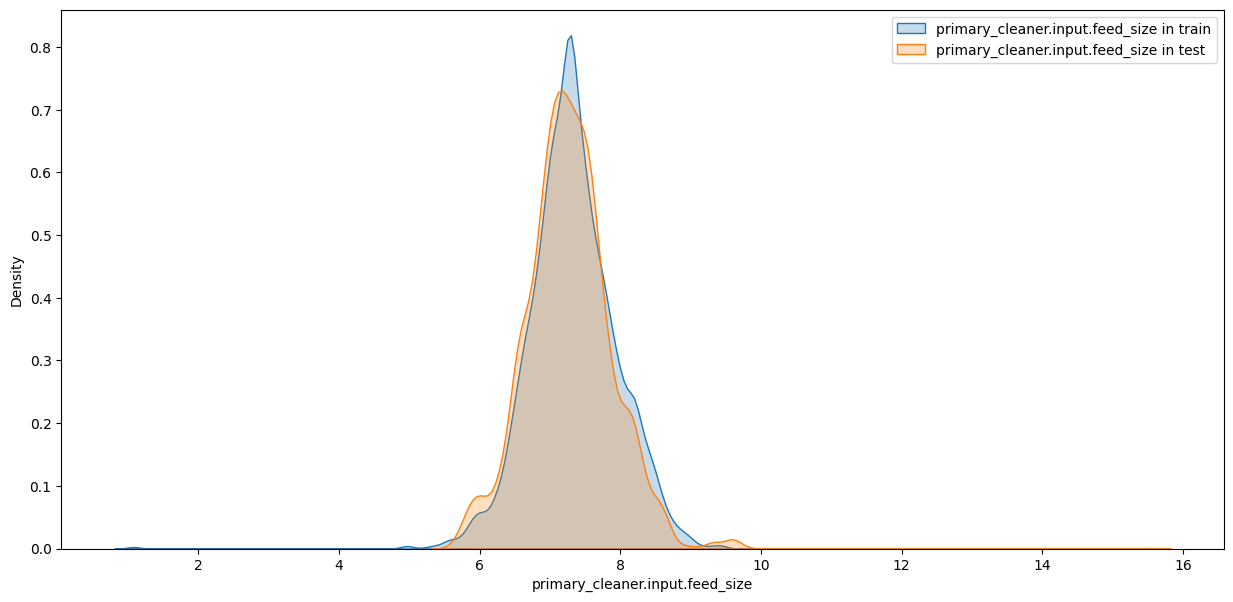



median of rougher.input.feed_size in train = 55.395
median of rougher.input.feed_size in test = 50.847


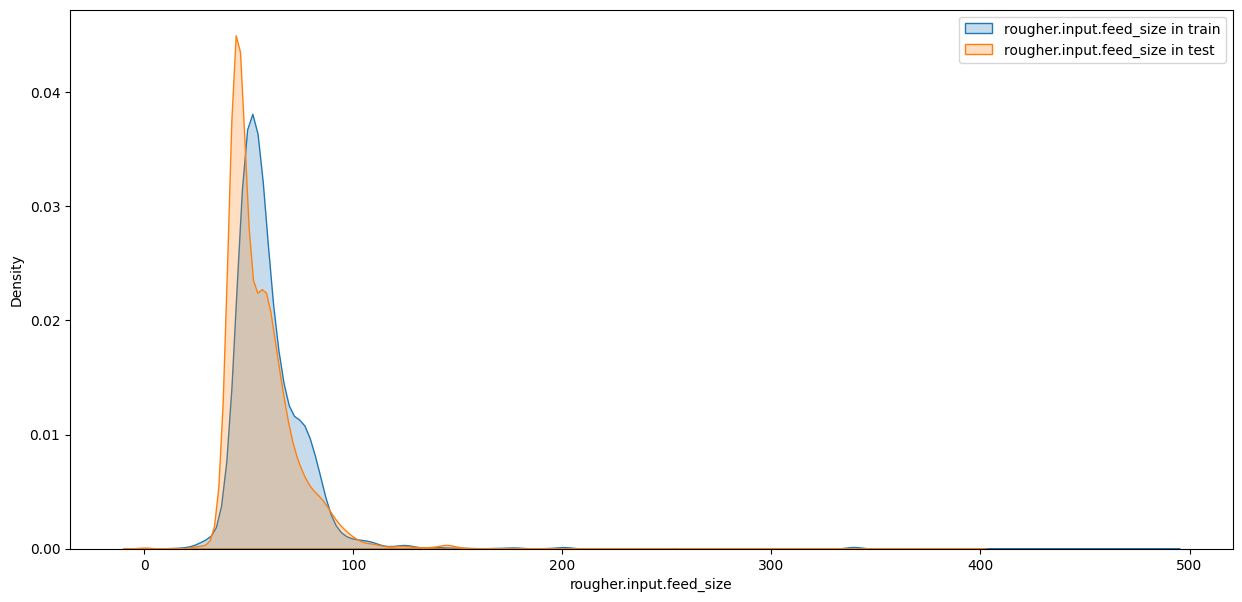

In [23]:
dict_df = {'train': train, 'test': test}
for param in str_in_param('feed_size', data):
    plt.figure(figsize=(15,7))
    for key in dict_df:
        print(f"median of {param} in {key} = {dict_df[key][param].median():.3f}")
        sns.kdeplot(dict_df[key][param], label=f'{param} in {key}', fill=True);
    plt.legend(loc='best')
    plt.show();
    print('\n')

**We see that the distribution of granule sizes at each of the corresponding stages is very similar for the test and training sets.**

### We study the total concentration of all substances at different stages

In [24]:
display(str_in_param('concentrate', data)) #check what concentration parameters we have in the data
str_in_param('feed_', data) #check what concentration parameters we have in the data for the feedstock

['final.output.concentrate_ag',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.concentrate_au',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.concentrate_au',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.concentrate_au']

['primary_cleaner.input.feed_size',
 'rougher.input.feed_ag',
 'rougher.input.feed_pb',
 'rougher.input.feed_rate',
 'rougher.input.feed_size',
 'rougher.input.feed_sol',
 'rougher.input.feed_au']

**We see that there are four substances of interest to us at each of the four stages:**
- `ag`,
- `pb`,
- `sol`,
- `au`.

**Let us now check the distribution of the total concentration of these four substances at each of the four stages.**

median of rougher.input.feed_sum = 57.594
median of rougher.output.concentrate_sum = 70.181
median of primary_cleaner.output.concentrate_sum = 62.498
median of final.output.concentrate_sum = 69.598


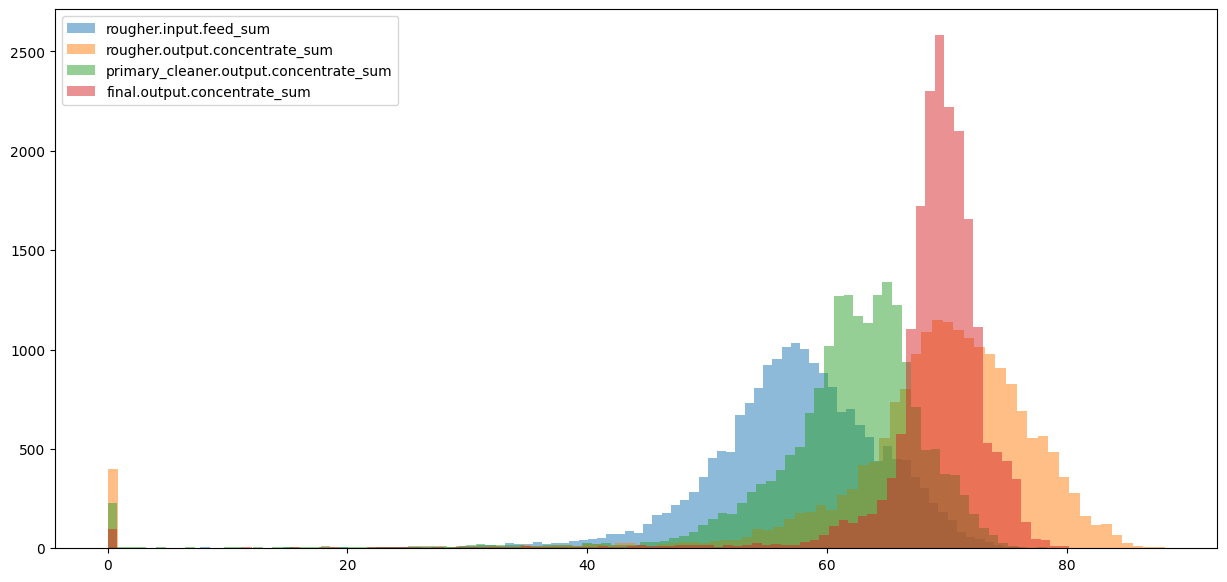

In [25]:
dict_param = {
    'rougher.input': 'rougher.input.feed',
    'rougher.output': 'rougher.output.concentrate',
    'primary_cleaner': 'primary_cleaner.output.concentrate',
    'final': 'final.output.concentrate'
             }
df = data.copy()
sum_str = '_sum'
plt.figure(figsize=(15,7))
for key in dict_param:
    df[dict_param[key]+sum_str] = df[
        [x for x in str_in_param(dict_param[key], df) if ('_size' not in x) and ('_rate' not in x)]
                                    ].sum(axis=1)
    print(f"median of {dict_param[key]+sum_str} = {df[dict_param[key]+sum_str].median():.3f}")
    plt.hist(df[dict_param[key]+sum_str], bins=100, alpha=0.5, label=f'{dict_param[key]+sum_str}')
plt.legend(loc='best')
plt.show()

**We see a rather strange picture: the total concentration in the initial raw material is minimal, then in the rough concentrate and the final concentrate it is almost the same and reaches maximum values, but in the concentrate after primary purification it is less than the concentration in the rough concentrate, but more than in the original raw materials. Perhaps this is somehow connected with the technological process and at this stage some part of these substances to a greater extent goes into waste tailings or is converted into something else.**

**In the total concentration data there are outlier values equal to zero, which are anomalies (total concentration of substances = 0 is clearly a strange phenomenon) and can affect the further operation of the model and the sMAPE metric, it is necessary to estimate what percentage of the data covers these values in the training set, Let's do it below.**

In [26]:
index_zero_sum_conc = [] #list of indices in the source data, where the total concentration at at least one of the stages = 0
# #conc_param_list = [] #list of all metal concentration parameters

for param in str_in_param('_sum', df):
     index_zero_sum_conc.extend(df[df[param] == 0].index)
print(f'Percentage of source data where at least one of the parameters of the total concentration is equal to zero: {len(index_zero_sum_conc)/len(df)*100:.3f}')

Percentage of source data where at least one of the parameters of the total concentration is equal to zero: 3.087


**We see that the percentage of these outlier values in the original data is not large, so rows with this value can be discarded in the training set. Let's do this using the `date` feature from the source data.**

In [27]:
time2_to_del = df.iloc[index_zero_sum_conc]['date'].tolist()
train_no_zer_sum_conc = train[~train['date'].isin(time2_to_del)]
train_zer_sum_conc = train[train['date'].isin(time2_to_del)]
print(f"Percentage of data removed from training set = {(100*len(train_zer_sum_conc)/len(train)):.3f}")
train = train[~train['date'].isin(time2_to_del)]

Percentage of data removed from training set = 0.000


**We see that from the training sample there is no data that contains a time stamp corresponding to the total concentration of substances at any stage of the technological process, equal to zero.**

## Model

### Function for calculating the final sMAPE

In [30]:
def smape(target, predict):
    """The function for calculating the sMAPE metric takes two pandas.df\series as input - a target and a predictor"""
    smape = 0
    #standardize the indices of two samples
    target_stnd = pd.DataFrame(target).reset_index(drop=True)
    predict_stnd = pd.DataFrame(predict).reset_index(drop=True)

    #create a common dataframe
    merged_df = pd.merge(target_stnd, predict_stnd, left_index=True, right_index=True, how='left')
    #create a parameter module of the difference between the predictor and the target
    merged_df['abs_of_diff'] = abs(merged_df[merged_df.columns[0]] - merged_df[merged_df.columns[1]])
    #create the parameter sum of predict and target modules
    merged_df['sum_of_abs'] = abs(merged_df[merged_df.columns[0]]) + abs(merged_df[merged_df.columns[1]])
    #create the parameter compound member smape according to the proposed formula (the part under the sum sign)
    merged_df['smape_unit'] = 200 * merged_df['abs_of_diff'] / merged_df[merged_df['sum_of_abs'] != 0]['sum_of_abs']
    #calculate smape according to the proposed formula
    smape = merged_df['smape_unit'].sum() / len(merged_df)
    return smape

def overall_smape(smape_rougher, smape_final):
    """
    Function for calculating the final sMAPE metric
    """
    overall_smape = 0.25 * smape_rougher + 0.75 * smape_final
    return overall_smape

**Before using samples for training and testing models, you must remove parameters with a non-numeric data type - the `date` parameter, scale and divide the samples into features and target.**

In [31]:
train = train.drop(['date'], axis=1) #delete the non-numeric date parameter
test = test.drop(['date'], axis=1) #delete the non-numeric date parameter
columns_diff(train, test) # check the coincidence of parameters in two samples

'The parameters/columns of the two samples are not different'

**Let's select the features and target subsamples from the training and test samples and scale the parameters.**

In [32]:
def target_features_div(target, df):
     """
     A function that splits the original sample into features and target
     """
     features_df = df.drop(target, axis=1)
     target_df = df[target]
     return features_df, target_df

features_train, target_train = target_features_div(['rougher.output.recovery', 'final.output.recovery'], train)
features_test, target_test = target_features_div(['rougher.output.recovery', 'final.output.recovery'], test)

# normalize numerical features
scaler = MinMaxScaler()
scaler.fit(features_train)
features_train = pd.DataFrame(scaler.transform(features_train))
features_test = pd.DataFrame(scaler.transform(features_test))

print('Training set information')
print('Features_train size')
display(features_train.shape)
print('Target_train size')
display(target_train.shape)

print(2*'\n'+'Test sample information')
print('Features_test size')
display(features_test.shape)
print('Target_test size')
display(target_test.shape)

print('Differences between features_train and features_test samples:')
columns_diff(features_train, features_test)

Training set information
Features_train size


(13720, 52)

Target_train size


(13720, 2)



Test sample information
Features_test size


(5290, 52)

Target_test size


(5290, 2)

Differences between features_train and features_test samples:


'The parameters/columns of the two samples are not different'

** Because in the case of our task, we have two separate target features; it is necessary to divide the target samples obtained above into two - with the suffixes rougher and final.**

In [33]:
target_test_rougher = target_test['rougher.output.recovery']
target_train_rougher = target_train['rougher.output.recovery']
target_test_final = target_test['final.output.recovery']
target_train_final = target_train['final.output.recovery']

### Training models and assessing their quality using cross-validation

**For the current task, I suggest choosing two models - linear regression and decision tree. We will use one of them to predict one target feature, the second - for another target feature. To search for a set of hyperparameters that give the best result of the sMAPE metric, we will use the GridSearchCV tool, which also uses cross-validation in its mechanism, which satisfies the conditions of our task.**

#### Linear regression and target feature rougher.recovery

In [34]:
model_linreg_rougher = LinearRegression()
smap_scorer = make_scorer(score_func=smape, greater_is_better=False)
gridsearch_linreg_rougher = GridSearchCV(estimator=model_linreg_rougher, param_grid={}, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_linreg_rougher.fit(features_train, target_train_rougher)
print(f'sMAPE lin_reg {-1 * gridsearch_linreg_rougher.best_score_}')

sMAPE lin_reg 7.266314229938177


#### Linear regression and target feature final.recovery

In [35]:
model_linreg_final = LinearRegression()
gridsearch_linreg_final = GridSearchCV(estimator=model_linreg_final, param_grid={}, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_linreg_final.fit(features_train, target_train_final)
print(f'sMAPE lin_reg {-1 * gridsearch_linreg_final.best_score_}')

sMAPE lin_reg 10.947561977457552


#### Decision tree regressor and target feature rougher.recovery

In [36]:
model_dtr_rougher = DecisionTreeRegressor(random_state=1)
parameters_dtr_rougher = {'max_depth':range(1,13,2),
                          'criterion':['poisson', 'friedman_mse'],
                          'min_samples_split':range(2,10,2)}
gridsearch_dtr_rougher = GridSearchCV(estimator=model_dtr_rougher, param_grid=parameters_dtr_rougher, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dtr_rougher.fit(features_train, target_train_rougher)
print(f'Best parameters dec_tree_reg {gridsearch_dtr_rougher.best_params_}')
print(f'sMAPE dec_tree_reg {-1 * gridsearch_dtr_rougher.best_score_}')

Best parameters dec_tree_reg {'criterion': 'poisson', 'max_depth': 3, 'min_samples_split': 2}
sMAPE dec_tree_reg 7.324654231530604


#### Decision tree regressor and target feature  final.recovery

In [37]:
model_dtr_final = DecisionTreeRegressor(random_state=1)
parameters_dtr_final = {'max_depth':range(1,13,2),
                        'criterion':['poisson', 'friedman_mse'],
                        'min_samples_split':range(2,10,2)}
gridsearch_dtr_final = GridSearchCV(estimator=model_dtr_final, param_grid=parameters_dtr_final, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dtr_final.fit(features_train, target_train_final)
print(f'Best parameters dec_tree_reg {gridsearch_dtr_final.best_params_}')
print(f'sMAPE dec_tree_reg {-1 * gridsearch_dtr_final.best_score_}')

Best parameters dec_tree_reg {'criterion': 'friedman_mse', 'max_depth': 3, 'min_samples_split': 2}
sMAPE dec_tree_reg 9.429629211565247


**From this we conclude that of the selected two models, the best result for the final.recovery feature was shown by the decision tree regression model, and for the rougher.recovery feature, the best result was shown by the linear regression model.**

**Now let’s check the selected models on the test sample.**

In [38]:
best_model_final = gridsearch_dtr_final.best_estimator_
best_model_rougher = gridsearch_linreg_rougher.best_estimator_
smape_test_rougher = smape(target_test_rougher, best_model_rougher.predict(features_test))
smape_test_final = smape(target_test_final, best_model_final.predict(features_test))
print(f'sMAPE on the test sample for the target parameter rougher = {smape_test_rougher:.3f}')
print(f'sMAPE on the test sample for the target parameter final = {smape_test_final:.3f}')
print(f'Final sMAPE on the test sample = {overall_smape(smape_test_rougher, smape_test_final):.3f}')

sMAPE on the test sample for the target parameter rougher = 8.563
sMAPE on the test sample for the target parameter final = 9.925
Final sMAPE on the test sample = 9.584


**Conclusion.**

**In the end, the best result was obtained by a combination of two models for each of the target features, namely linear regression for the rougher.recovery parameter and a decision tree for the final.recovery parameter. The final sMAPE value on the test sample was 9.584.**

## Checking models for adequacy

**Let's check the selected models for adequacy using the Dummy Model from the sklearn class, having previously imported it in the first step.**

**The check is that the quality of the trained model chosen above is higher than the quality of the Dummy model, which predicts the result without relying on the features of the training set.**

In [39]:
#dummy for the rougher.recovery parameter
model_dummy_rougher = DummyRegressor()
parameters_dummy_rougher = {'strategy':['mean', 'median', 'constant'],
                             'constant':(0,100,1)}
gridsearch_dummy_rougher = GridSearchCV(estimator=model_dummy_rougher, param_grid=parameters_dummy_rougher, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dummy_rougher.fit(features_train, target_train_rougher)
print(f'Best dummy parameters for rougher.recovery {gridsearch_dummy_rougher.best_params_}')
print(f'sMAPE-dummy rougher.recovery {abs(gridsearch_dummy_rougher.best_score_)}')

Best dummy parameters for rougher.recovery {'constant': 0, 'strategy': 'mean'}
sMAPE-dummy rougher.recovery 7.802275782795165


In [40]:
# dummy for the final.recovery parameter
model_dummy_final = DummyRegressor()
parameters_dummy_final = {'strategy':['mean', 'median', 'constant'],
                           'constant':(0,100,1)}
gridsearch_dummy_final = GridSearchCV(estimator=model_dummy_final, param_grid=parameters_dummy_final, scoring=smap_scorer, cv=5, n_jobs=-1)
gridsearch_dummy_final.fit(features_train, target_train_final)
print(f'Best dummy parameters for final.recovery {gridsearch_dummy_final.best_params_}')
print(f'sMAPE-dummy final.recovery {abs(gridsearch_dummy_final.best_score_)}')

Best dummy parameters for final.recovery {'constant': 0, 'strategy': 'mean'}
sMAPE-dummy final.recovery 10.403313462592402


In [41]:
best_dummy_final = gridsearch_dummy_final.best_estimator_
best_dummy_rougher = gridsearch_dummy_rougher.best_estimator_
smape_test_dummy_rougher = smape(target_test_rougher, best_dummy_rougher.predict(features_test))
smape_test_dummy_final = smape(target_test_final, best_dummy_final.predict(features_test))
print(f'sMAPE-dummy on the test sample for the target parameter rougher = {smape_test_dummy_rougher:.3f}')
print(f'sMAPE-dummy on the test sample for the target parameter final = {smape_test_dummy_final:.3f}')
print(f'Final sMAPE-dummy on the test sample = {overall_smape(smape_test_dummy_rougher, smape_test_dummy_final):.3f}')

sMAPE-dummy on the test sample for the target parameter rougher = 9.063
sMAPE-dummy on the test sample for the target parameter final = 10.084
Final sMAPE-dummy on the test sample = 9.829


## CONCLUSION

**As a result, using the Dummy model, it was possible to obtain the best quality of the model with a final sMAPE equal to 9.829 when choosing the strategy of filling with average values, which is lower than the best result of the selected and trained linear regression and decision tree regression models, the combination of which gave a final sMAPE result equal to 9.584. Which proves the adequacy of the model we found.**

**There is no target for the final sMAPE metric in the initial conditions of the problem; in the future we can modify models to improve the sMAPE metric by selecting hyperparameters or by testing other models.**